- Diana Zaray Corado #191025
- Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
- Javier Alejandro Mejía Alecio #20304
- Erick Raúl Alvarez Melgar #20900

# Proyecto - Análisis Exploratorio

Guatemala es conocido como el país de la eterna primavera, debido a su diversidad de flora y fauna, además de contar
con un clima conocido como templado, es decir no existen climas extremos a lo largo del año. Sin embargo, así como
es conocido por su belleza natural, también es fuertemente reconocible por la corrupción y los bajos índices de calidad
de vida, y uno de ellos es el de mortalidad, la cual expresa la frecuencia con la cual ocurren las defunciones en una
población dada, en el caso de Guatemala, para el año 2019 fue de 4.72% (Datosmacro, 2021), es decir en promedio 5 muertes por cada 1000 habitantes.
A continuación se realizará un análisis exploratorio, sobre los datos de defunciones reportados por el Instituto Nacional de
Estadística de Guatemala -INE- de los años 2011 a 2020, y dentro de los cuales se pretende encontrar una situación problemática
la cual a su vez pueda ser resuelta con los datos analizados.

In [160]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree
import sklearn.metrics as skm

# Estilos
plt.style.use('ggplot')
sns.set_theme(palette=None)

In [68]:
# Cargar los datos
deaths = pd.read_csv('final.csv')
# Como ya se cuenta con la causa de muerte (categorizada) la descripción sale sobrando
# De igual forma, el periodo de edad se puede obtener mediante la edad así que es info redundante
deaths = deaths.loc[:, deaths.columns != 'Perdif']
deaths = deaths.loc[:, deaths.columns != 'caudef.descrip']

C:\Users\Zaray\AppData\Local\Temp\ipykernel_17096\1461672132.py:2: DtypeWarning: Columns (7,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  deaths = pd.read_csv('final.csv')


In [70]:
deaths['cause'] = deaths['Caudef'].copy()
repl = {r'([AB])(\d+.*)' : r'AB',
        r'(C)(\d+.*)' : r'CD',
        r'(D[0-4])(\d+.*)' : r'CD',
        r'(D[5-8])(\d+.*)' : r'DD',
        r'(E)(\d+.*)' : r'EE',
        r'(F)(\d+.*)' : r'FF',
        r'(G)(\d+.*)' : r'GG',
        r'(H[0-5])(\d+.*)' : r'HA',
        r'(H[6-9])(\d+.*)' : r'HB',
        r'(I)(\d+.*)' : r'II',
        r'(J)(\d+.*)' : r'JJ',
        r'(K)(\d+.*)' : r'KK',
        r'(L)(\d+.*)' : r'LL',
        r'(M)(\d+.*)' : r'MM',
        r'(N)(\d+.*)' : r'NN',
        r'(O)(\d+.*)' : r'OO',
        r'(P)(\d+.*)' : r'PP',
        r'(Q)(\d+.*)' : r'QQ',
        r'(R)(\d+.*)' : r'RR',
        r'([ST])(\d+.*)' : r'ST',
        r'([VWXY])(\d+.*)' : r'VY',
        r'([Z])(\d+.*)' : r'ZZ',
        r'([U])(\d+.*)' : r'UU',
        }
deaths.cause = deaths['cause'].replace(repl, regex=True)
deaths['cause']

0         II
1         UU
2         RR
3         PP
4         UU
          ..
809291    AB
809292    AB
809293    AB
809294    AB
809295    AB
Name: cause, Length: 809296, dtype: object

In [71]:
# Eliminación de toda la información pertinente al difunto en sí, porque no se pretende trabajar con los difuntos en sí
sample = deaths.drop(['Areag', 'Depreg', 'Mupreg', 'Mesreg', 'Añoreg','Depocu','Edadif','Puedif','Ecidif','Escodif','Ciuodif','Pnadif','Dnadif','Mnadif', 'Nacdif', 'Predif', 'Dredif', 'Mredif', 'Sexo', 'Caudef'], axis=1)

In [72]:
# Creación de la nueva variable de predicción
# Variable de predicción: número de muertes por municipio_ocurrencia/mes_ocurrencia y causa
sample = sample.groupby(by=['cause','Mupocu', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur', 'Cerdef']).count()
sample.columns = ['number_deaths']

In [73]:
# Nuevo conjunto de datos
sample = sample.reset_index(level=['cause', 'Mesocu', 'Diaocu', 'Añoocu', 'Asist', 'Ocur','Cerdef','Mupocu'])

Cruce las variables que considere que son las más importantes para hallar los elementos clave que lo pueden llevar a
comprender lo que está causando el problema encontrado.

Para hacer el cruce de las variables y comprender si existe cierta asociación entre dichas variables se utilizará Cramer´s V
la cual es una medida de la longitud entre variables categóricas, básicamente mide la relación entre las variables. Su valor
varía de 0 a 1, donde 0 indica que no existe ningún tipo de asociación entre las variables y 1 que sí existe asociación entre
las mismas. Por otro lado, también se utilizarán las tablas de contingencia para hacer el "cruce" de las variables.

Durante el análisis exploratorio de los datos y mediante las diversas preguntas que se plantearon para conocer dichos datos
se pudo encontrar que existe una gran parte de las defunciones las cuales NO reciben asistencia médica, y esto es más notorio
cuando se habla de asistencia médica por pueblo de pertenencia. Por lo tal, se evaluará únicamente la asociación de las variables
con respecto al tipo de asistencia que reciben.

In [74]:
# Evaluar la correlación de las variables para ver cuáles se pueden eliminar
for column in sample.columns:
  if column != 'cause':
    crosstable = pd.crosstab(sample[column], sample['cause'])
    print(crosstable)
    print('Asociación: ', contingency.association(crosstable))

cause         AB   CD  DD   EE  FF  GG  HA  HB   II   JJ   KK  LL  MM  NN  OO  \
Mupocu                                                                          
Acatenango    26  139   6   60   4  18   0   0  189  149   89   1   3  18   0   
Agua Blanca   10  112   3   84   1   3   0   0  314   93   36   0   1  15   0   
Aguacatán    190  284  11  146  13  37   0   0  343  328  144   2  11  84  10   
Almolonga     15  102   7  220  13  13   0   0  183  101  109   0  10  46   0   
Alotenango    31   72  11  130  10  19   0   0  201  156   56   3   2  24   0   
...          ...  ...  ..  ...  ..  ..  ..  ..  ...  ...  ...  ..  ..  ..  ..   
Zacualpa     174  118  15  101  20  20   0   1  134  214   89   3   2  36   3   
Zapotitlán     8   64   1   34   1   4   0   0  139   16   10   0   0  15   0   
Zaragoza      12  125   1   80  19  10   0   0  144  117   96   3   7  27   0   
Zunil         15   66   6  126   8  15   0   0  136   56   65   0   0  30   2   
Zunilito       7   32   0   

In [75]:
sample = sample.drop(['Asist', 'Diaocu', 'Cerdef'], axis=1)

In [76]:
sample = sample.groupby(['cause', 'Mesocu', 'Añoocu', 'Ocur','Mupocu']).count()
sample = sample.reset_index(level=['cause', 'Mesocu', 'Añoocu', 'Ocur','Mupocu'])

In [140]:
deaths_sample = sample.groupby('cause', group_keys=False).apply(lambda x: x.sample(frac=0.50, random_state=191943))


In [138]:
deaths_sample

,cause,Mesocu,Añoocu,Ocur,Mupocu,number_deaths
7186,0,5,0,3,317,1
5230,0,3,6,1,238,0
14275,0,9,9,1,205,0
7797,0,5,4,3,68,5
7640,0,5,3,3,6,1
...,...,...,...,...,...,...
277422,19,8,9,4,241,0
276888,19,8,7,8,325,1
273705,19,7,9,6,88,0
257933,19,3,7,8,97,0


In [171]:
# Codificación de las variables
encoder = OrdinalEncoder(dtype=int)
for column in sample.columns:
        if column != 'Añoocu' and column != 'number_deaths':
                sample[column] = encoder.fit_transform(sample[[column]])
                print(encoder.categories_)

[array(['AB', 'CD', 'DD', 'EE', 'FF', 'GG', 'HA', 'HB', 'II', 'JJ', 'KK',
       'LL', 'MM', 'NN', 'OO', 'PP', 'QQ', 'RR', 'UU', 'VY'], dtype=object)]
[array(['Abril', 'Agosto', 'Diciembre', 'Enero', 'Febrero', 'Julio',
       'Junio', 'Marzo', 'Mayo', 'Noviembre', 'Octubre', 'Septiembre'],
      dtype=object)]
[array(['Centro de salud', 'Domicilio', 'Hospital privado',
       'Hospital público', 'Ignorado', 'Lugar de trabajo', 'Otro',
       'Seguro social', 'Vía pública'], dtype=object)]
[array(['Acatenango', 'Agua Blanca', 'Aguacatán', 'Almolonga',
       'Alotenango', 'Amatitlán', 'Antigua Guatemala', 'Asunción Mita',
       'Atescatempa', 'Ayutla', 'Barberena', 'Barillas', 'Cabañas',
       'Cabricán', 'Cahabón', 'Cajolá', 'Camotán', 'Canillá', 'Cantel',
       'Casillas', 'Catarina', 'Chahal', 'Chajul', 'Champerico',
       'Chiantla', 'Chicacao', 'Chicamán', 'Chichicastenango', 'Chiché',
       'Chimaltenango', 'Chinautla', 'Chinique', 'Chiquimula',
       'Chiquimulilla', 'Chis

In [172]:
# Variables para predecir
target = sample.number_deaths
predictors = sample.loc[:, sample.columns != 'number_deaths']

In [173]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.3, stratify=predictors['cause'])


In [187]:
regression_model = DecisionTreeRegressor(max_depth=15, random_state=42)
regression_model = regression_model.fit(X=predictors_train, y=target_train)

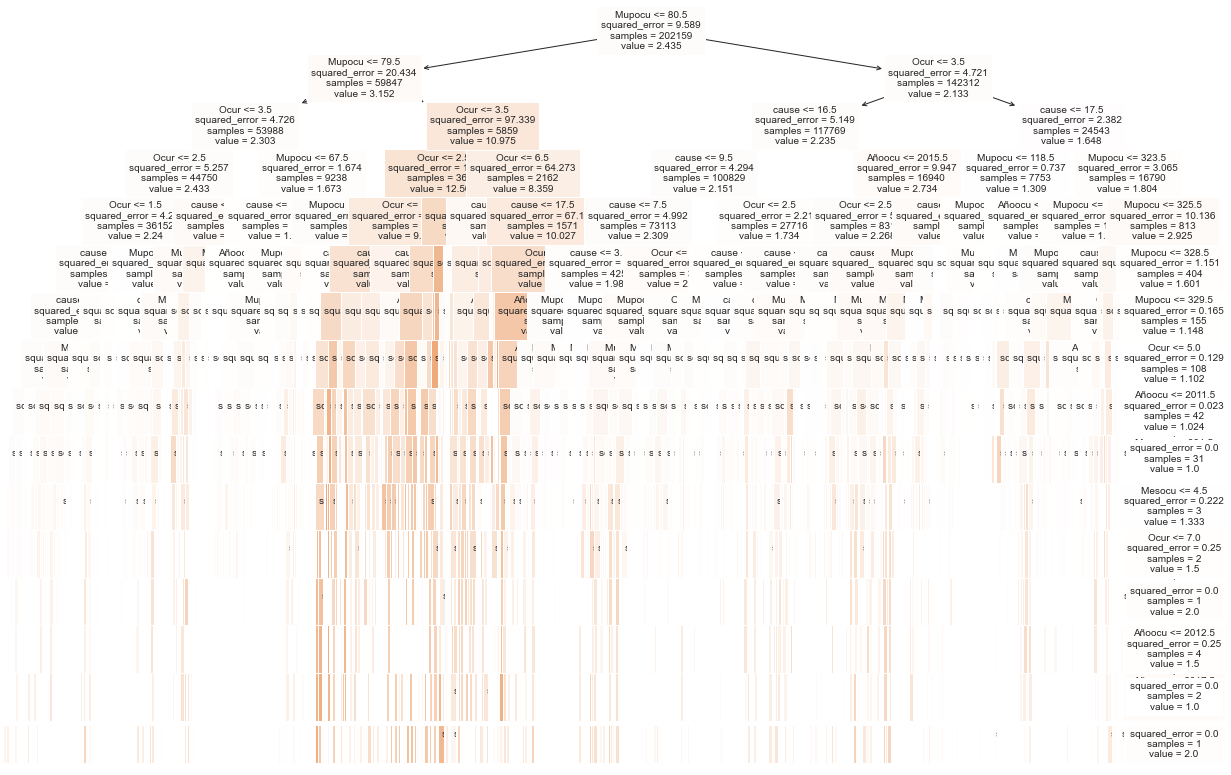

In [190]:
plt.figure(figsize=(20, 14))
plot_tree(decision_tree=regression_model,feature_names=predictors.columns, filled=True, fontsize=10);

In [188]:
# Evaluando la predicción
prediction = regression_model.predict(predictors_test)
results = pd.DataFrame({
    'Predicted': prediction,
    'Real': target_test
})

results

,Predicted,Real
248467,5.000000,4
45277,1.153226,1
185960,1.114865,1
218275,1.358491,1
217621,1.000000,1
...,...,...
225317,12.142857,14
70004,1.985696,2
220718,6.531250,4
138465,2.270000,4


In [189]:
print ("Variance Score:",skm.explained_variance_score(target_test, prediction, multioutput='raw_values'))
print ("Max Error:", skm.mean_absolute_error(target_test, prediction))

Variance Score: [0.72301194]
Max Error: 0.997949897665015
